## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading the dataset

In [3]:
df= pd.read_excel(r"C:\Users\Shweta\Desktop\Python\classification_assignement_OrbitShift.xlsx")

## Check records per class

In [4]:
df['label'].value_counts()

CLASS13    489
CLASS4     373
CLASS5     300
CLASS6     263
CLASS8     225
CLASS7     168
CLASS10    119
CLASS3      94
CLASS11     81
CLASS1      76
CLASS2      40
CLASS9      28
CLASS12      3
Name: label, dtype: int64

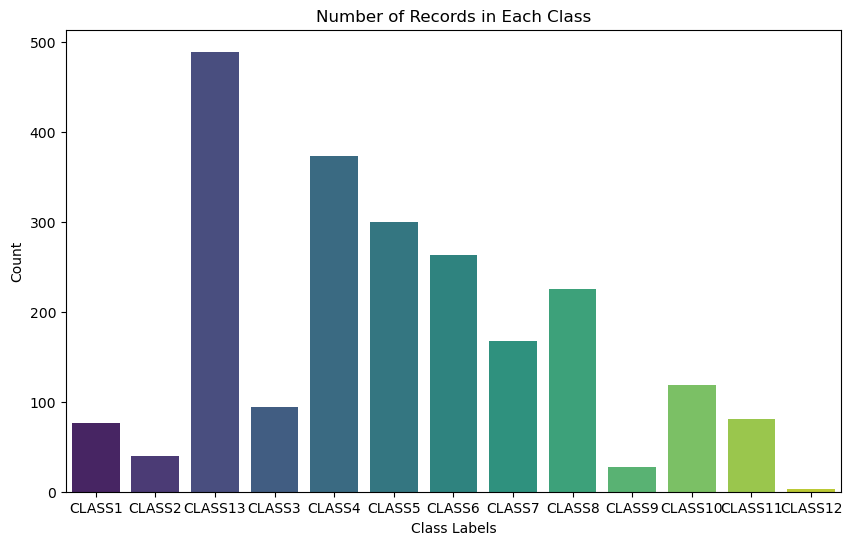

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Number of Records in Each Class')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.show()

We can see the imbalance in the records in the dataset over various classes. To be able to handle this imbalance when training the model, we can use Oversampling.

## Cleaning the title column

In the data, we find values like 2022, 2023, and other pattern which might reduce the quality of trainin model to predict the true class for a title. Hence,, a code to clean the title column is given below:

In [13]:
import re
# Define a function to remove unwanted patterns
def clean_title(title):
    # Remove non-alphanumeric characters except spaces
    cleaned_title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
    return cleaned_title

# Apply the function to the 'title' column
df['title'] = df['title'].apply(clean_title)

In [14]:
df['title'] = df['title'].str.replace(r'2022|2023|20222023', '', regex=True)

In [15]:
df.head()

,title,label
0,Director Learning and Support,CLASS1
1,Customer Service Assistant,CLASS2
2,Internship and Education Program Management I...,CLASS13
3,Communications Technician,CLASS13
4,Emergency Preparedness Officer,CLASS3


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2259 entries, 0 to 2258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   2259 non-null   object  
 1   label   2259 non-null   category
dtypes: category(1), object(1)
memory usage: 38.1+ KB


In [17]:
df.drop_duplicates(keep = 'first', inplace = True)

In [18]:
df.shape

(2255, 2)

## Oversampling

In [19]:
df['label'] = df['label'].astype('category')

target_count = 300 

oversampled_df = df.copy()

class_counts = df['label'].value_counts()

for label, count in class_counts.items():
    if count < target_count:
        #print(label)
        oversample_count = target_count - count
        current_class_df = df[df['label'] == label]
        #Oversampling
        oversampled_samples = current_class_df[current_class_df['label']== label].sample(oversample_count, replace=True, random_state=42)
        oversampled_df = pd.concat([oversampled_df, oversampled_samples], axis=0, ignore_index=True)
    

# Display balanced dataset
oversampled_df['label'].value_counts()

CLASS13    489
CLASS4     373
CLASS1     300
CLASS10    300
CLASS11    300
CLASS12    300
CLASS2     300
CLASS3     300
CLASS5     300
CLASS6     300
CLASS7     300
CLASS8     300
CLASS9     300
Name: label, dtype: int64

In [20]:
import torch

In [21]:
oversampled_df = df.copy()

## Split the dataset to train, validate and test

In [22]:
X_tmp, X_test, y_tmp, y_test = train_test_split(oversampled_df['title'], oversampled_df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)

In [23]:
#Tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

X_train_tokens = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
X_val_tokens = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')
X_test_tokens = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    X_train_embeddings = model(**X_train_tokens).last_hidden_state
    X_val_embeddings = model(**X_val_tokens).last_hidden_state
    X_test_embeddings = model(**X_test_tokens).last_hidden_state

X_train_mean = X_train_embeddings.mean(dim=1)
X_val_mean = X_val_embeddings.mean(dim=1)
X_test_mean = X_test_embeddings.mean(dim=1)

## Logistic Regression

In [26]:
#logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_mean.numpy(), y_train)

LogisticRegression(max_iter=1000)

In [27]:
# validation accuracy
val_predictions = classifier.predict(X_val_mean.numpy())

accuracy_val = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {accuracy_val:.2%}")

Validation Accuracy: 57.06%


In [28]:
# test accuracy
test_predictions = classifier.predict(X_test_mean.numpy())

accuracy_test = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {accuracy_test:.2%}")


Test Accuracy: 52.55%


In [30]:
import pickle

print("Classification Report on Test Set:")
print(classification_report(y_test, test_predictions))

with open("few_shot_classifier.pkl", "wb") as model_file:
    pickle.dump(classifier, model_file)

Classification Report on Test Set:
              precision    recall  f1-score   support

      CLASS1       0.57      0.36      0.44        11
     CLASS10       0.69      0.48      0.56        23
     CLASS11       0.69      0.53      0.60        17
     CLASS12       0.00      0.00      0.00         1
     CLASS13       0.44      0.59      0.50        96
      CLASS2       0.50      0.50      0.50         6
      CLASS3       0.56      0.53      0.55        17
      CLASS4       0.61      0.61      0.61        84
      CLASS5       0.66      0.57      0.61        67
      CLASS6       0.42      0.44      0.43        52
      CLASS7       0.39      0.34      0.37        32
      CLASS8       0.47      0.41      0.43        37
      CLASS9       1.00      0.75      0.86         8

    accuracy                           0.53       451
   macro avg       0.54      0.47      0.50       451
weighted avg       0.54      0.53      0.53       451



C:\Users\Shweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
import pickle

with open('classifier.pkl', 'wb') as file:
    pickle.dump(classifier, file)

with open('classifier.pkl', 'rb') as file:
    loaded_classifier = pickle.load(file)

# Example
example_text = ("Internship","Intraday","Financial")
example_tokens = tokenizer(example_text, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    example_embeddings = model(**example_tokens).last_hidden_state
    example_mean = example_embeddings.mean(dim=1)
    prediction = loaded_classifier.predict(example_mean.numpy())

print("Prediction:", prediction)

Prediction: ['CLASS13' 'CLASS6' 'CLASS10']
